In this notebook, I am going to explore feature selection for classification based on correlation. Let's start without further ado by loading a few necessary libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

I am going to generate a classification dataset via scikit-learn's **make_classification** method. The number of features will be 6, of which 3 will be informative, 1 redundant, and 1 useless. The number of useless features is calculated automatically based on how many features of other types are defined.

In [2]:
X, y = datasets.make_classification(n_samples=500,
                                           n_features=6,
                                           n_informative=3,
                                           n_redundant=1)

Let's now compute Pearson's correlation coefficient for our 6 features via Numpy's **corrcoef** method. Then, we'll plot a matrix of the correlation scores for the features.

In [3]:
corr = np.corrcoef(X, rowvar=False)

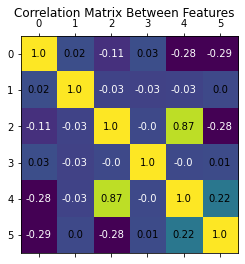

In [4]:
fig, ax = plt.subplots()

ax.matshow(corr)
#plt.colorbar()
fig.suptitle("Correlation Matrix Between Features")

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if corr[i, j] < 0:
            color = "white"
        else:
            color = "black"
        ax.text(i, j, round(corr[i, j], 2), color=color, 
                ha="center", va="center")

plt.show()

Now, what kind of a correlation score would make a good feature? Clearly, both negative and positive correlation can be very useful for predictions. Besides, isolating features just based on the correlation sign is difficult since a feature may be negatively correlated to one feature and positively to another.

Instead of looking at the sign, maybe we should pay attention to the absolute coefficient and omit features that show low correlation? This is the approach I chose for testing.

"Low" is subjective - in this particular example, I think that features 1 and 3 show the lowest correlation with other features. I will be omitting precisely these features when training the model.

Now, let's also create a Seaborn pairplot to get a more visual idea of the relationship between our features.

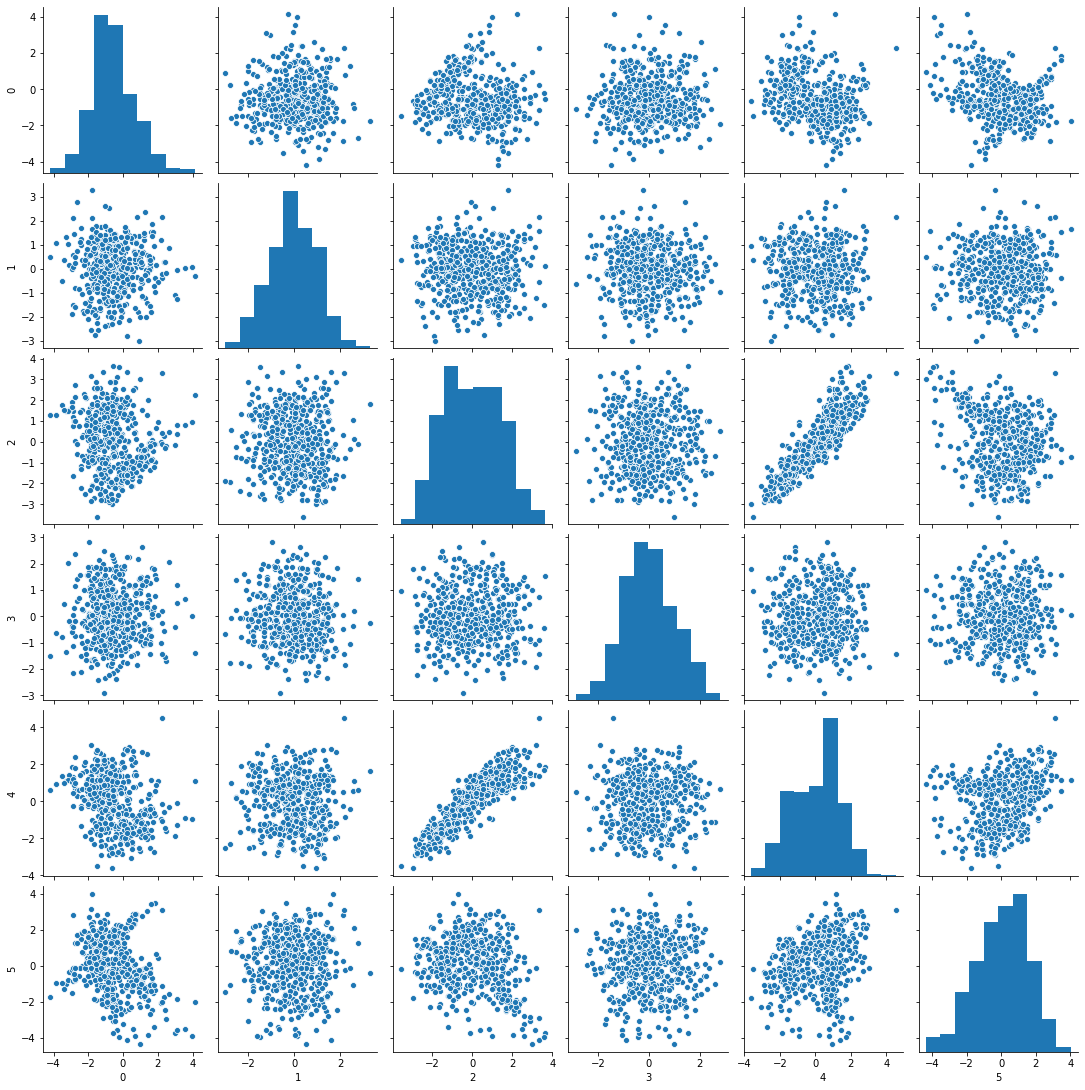

In [5]:
features = pd.DataFrame(X)

labels = pd.DataFrame(y)

sns.pairplot(features, kind="scatter")

Here, we again see that features 1 and 3 are weakly correlated to others. 0 and 5 also show pretty low correlation, but not ***as*** low.

Now, I'll define a function to plot a confusion matrix. I do this so that I avoid repeating the same code multiple times later.

In [6]:
def show_confusion_matrix(y_pred, title):
    fig, ax = plt.subplots()
    fig.suptitle(title)

    confusion_mat = confusion_matrix(y_test, y_pred)

    ax.matshow(confusion_mat)

    for i in range(2):
        for j in range(2):
            ax.text(i, j, confusion_mat[i, j], 
                    ha="center", va="center", fontsize=25, color="w")
            
    plt.show()

We are ready for testing. Let's start with a Support Vector Machine trained on all features.

SVM Performance On Training Data:  0.9573333333333334
SVM Performance On Test Data:  0.912

               precision    recall  f1-score   support

           0       0.90      0.92      0.91        60
           1       0.92      0.91      0.91        65

    accuracy                           0.91       125
   macro avg       0.91      0.91      0.91       125
weighted avg       0.91      0.91      0.91       125



c:\users\tigran\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


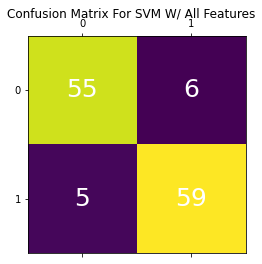

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# Baseline data & model
X_train_all, X_test_all, y_train, y_test = train_test_split(features, labels)

svc = SVC()

svc.fit(X_train_all, y_train)

print("SVM Performance On Training Data: ", svc.score(X_train_all, y_train))
print("SVM Performance On Test Data: ", svc.score(X_test_all, y_test))

y_pred = svc.predict(X_test_all)

print("\n", classification_report(y_test, y_pred))

show_confusion_matrix(y_pred, "Confusion Matrix For SVM W/ All Features")

This model shows good performance, but as evident from the difference between the training and testing scores, it overfits a bit. Still, not too bad.

Now, let's train an SVM with our "good features" - that is, all features except for 1 and 3.

In [8]:
# Only data with high negative or positive correlation
good_features = features.drop([1, 3], axis=1)
X_train_good, X_test_good, y_train, y_test = train_test_split(good_features, labels)

c:\users\tigran\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVM Performance On Training Data:  0.9413333333333334
SVM Performance On Test Data:  0.92

               precision    recall  f1-score   support

           0       0.94      0.91      0.92        67
           1       0.90      0.93      0.92        58

    accuracy                           0.92       125
   macro avg       0.92      0.92      0.92       125
weighted avg       0.92      0.92      0.92       125



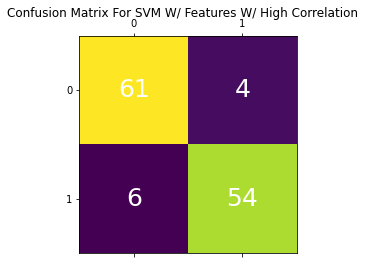

In [9]:
svc = SVC()

svc.fit(X_train_good, y_train)

print("SVM Performance On Training Data: ", svc.score(X_train_good, y_train))
print("SVM Performance On Test Data: ", svc.score(X_test_good, y_test))

y_pred = svc.predict(X_test_good)

print("\n", classification_report(y_test, y_pred))

show_confusion_matrix(y_pred, "Confusion Matrix For SVM W/ Features W/ High Correlation")

We achieved a lower  training score but a higher testing score. In other words, overfitting is lower with our "good features", but it's still there.

Let's now also try a Decision Tree Classifier - first on all and then only "good" features.

In [10]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

dtc.fit(X_train_all, y_train)

print("Decision Tree Training Score On All Features: ", dtc.score(X_train_all, y_train))
print("Decision Tree Test Score On All Features: ", dtc.score(X_test_all, y_test))
print("Estimated Feature Importances: ", dtc.feature_importances_)

Decision Tree Training Score On All Features:  1.0
Decision Tree Test Score On All Features:  0.488
Estimated Feature Importances:  [0.10494423 0.22643029 0.22385981 0.19133856 0.14517463 0.10825248]


In [11]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train_good, y_train)

print("Decision Tree Training Score On Good Features: ", dtc.score(X_train_good, y_train))
print("Decision Tree Test Score On Good Features: ", dtc.score(X_test_good, y_test))
print("Estimated Feature Importances: ", dtc.feature_importances_)

Decision Tree Training Score On Good Features:  1.0
Decision Tree Test Score On Good Features:  0.92
Estimated Feature Importances:  [0.12561204 0.6509386  0.11343056 0.11001879]


On all data, the Decision Tree Classifier shows low test performance, so it may be overfitting. I also printed feature importance scores, and it turns out that the model is paying more attention to the "bad" features than I would like.

In contrast, the model trained on just the "good" features performs way better, but it still shows some overfitting. I'd probably stick to SVM for real-world tasks with this particular dataset, but it was still interesting to see how model performance changes with feature selection.

As a final step, let's also determine feature importance via scikit-learn's **SelectKBest** class. This class requires a scoring function for instantiation, which will be **f_regression** in this case. **f_regression** is based on Pearson's coefficient (like Numpy's **corrcoef**), but it also does some other calculations that are beyond the scope of this work. 

What matters for us is that **SelectKBest's scores_** attribute will give us an idea of how important each feature is.

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression

scores = SelectKBest(f_regression, k='all').fit(features, labels)

c:\users\tigran\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


<BarContainer object of 6 artists>

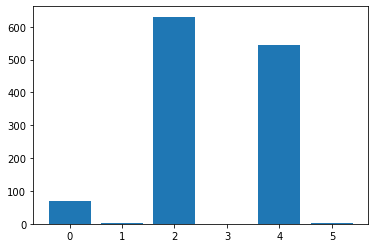

In [13]:
plt.bar(range(len(scores.scores_)), scores.scores_)

As it turns out, **SelectKBest** thinks that features 1, 3, and 5 are useless,  0 bears some usefulness. and features 2 and 4 are very important.

From our correlation matrix above, it's pretty clear why features 0, 1, 3, and 5 have low usability - their absolute coefficients are low. However, I subjectively didn't choose 5 as useless because it showed some correlation with features 0, 2, and 4.

To close this notebook off, let's train a final model without the "useless" features - 1, 3, and 5.

In [14]:
# Only features suggested by SelectKBest
final_features = features.drop([1, 3, 5], axis=1)
X_train_final, X_test_final, y_train, y_test = train_test_split(final_features, labels)

svc = SVC()

svc.fit(X_train_final, y_train)

print("SVM Performance On Training Data: ", svc.score(X_train_final, y_train))
print("SVM Performance On Test Data: ", svc.score(X_test_final, y_test))

SVM Performance On Training Data:  0.928
SVM Performance On Test Data:  0.912


c:\users\tigran\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [15]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train_final, y_train)

print("Decision Tree Training Score On Good Features: ", dtc.score(X_train_final, y_train))
print("Decision Tree Test Score On Good Features: ", dtc.score(X_test_final, y_test))
print("Estimated Feature Importances: ", dtc.feature_importances_)

Decision Tree Training Score On Good Features:  1.0
Decision Tree Test Score On Good Features:  0.848
Estimated Feature Importances:  [0.18356469 0.67181942 0.14461589]


The training score of the SVM model got lower, but the difference between training and test scores and thus overfitting was reduced. As for Decision Tree, its test results are pretty bad - this model might be overfitting.

So in the end, correlation does appear to have some role in feature selection, and it can be a useful metric for weeding out useless features. However, correlation alone may not be a good selection criterion, so other methods like **SelectKBest** should be used as well.

Besides, note that in this particular dataset, I did not cover the "correlation does not imply causation" thesis. In reality, this would be very important, and the data scientist would need to have in-depth knowledge of the data to identify actually useful correlation.